<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/minyak_goreng_merk1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f172afa7a60>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.minyak_goreng_kemasan_bermerk_1.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


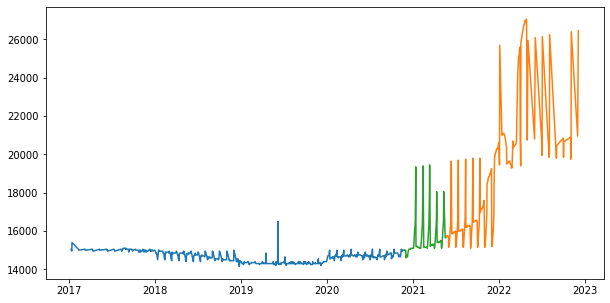

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [35]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_minyakgoreng1_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [11]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [12]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [13]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 27s 387ms/step - loss: 0.0579 - mae: 0.2350 - mape: 95.6970 - val_loss: 0.0531 - val_mae: 0.1844 - val_mape: 80.2460
Epoch 2/30
44/44 [==============================] - 9s 209ms/step - loss: 0.0397 - mae: 0.1931 - mape: 77.9366 - val_loss: 0.0416 - val_mae: 0.1499 - val_mape: 60.7175
Epoch 3/30
44/44 [==============================] - 9s 211ms/step - loss: 0.0288 - mae: 0.1621 - mape: 64.7755 - val_loss: 0.0343 - val_mae: 0.1231 - val_mape: 45.5830
Epoch 4/30
44/44 [==============================] - 9s 200ms/step - loss: 0.0213 - mae: 0.1374 - mape: 54.2426 - val_loss: 0.0292 - val_mae: 0.1034 - val_mape: 35.7379
Epoch 5/30
44/44 [==============================] - 9s 200ms/step - loss: 0.0160 - mae: 0.1164 - mape: 45.3680 - val_loss: 0.0256 - val_mae: 0.0893 - val_mape: 29.8822
Epoch 6/30
44/44 [==============================] - 9s 201ms/step - loss: 0.0119 - mae: 0.0978 - mape: 37.5700 - val_loss: 0.0231 - val_mae: 0.0798 - val_mape:

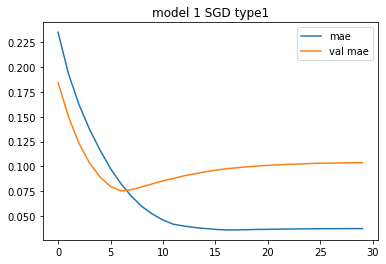

In [14]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 24ms/step
2641.3171 12.657404 3624.8227542874424


,date,actual,prediction
0,2021-05-20,15700,17071.259766
1,2021-05-21,15700,17071.685547
2,2021-05-24,15750,17074.820312
3,2021-05-25,15750,17073.964844
4,2021-05-27,15700,17079.119141
...,...,...,...
229,2022-11-02,19750,17197.806641
230,2022-11-03,20600,17249.261719
231,2022-11-04,26400,17189.306641
232,2022-12-01,20950,17247.111328


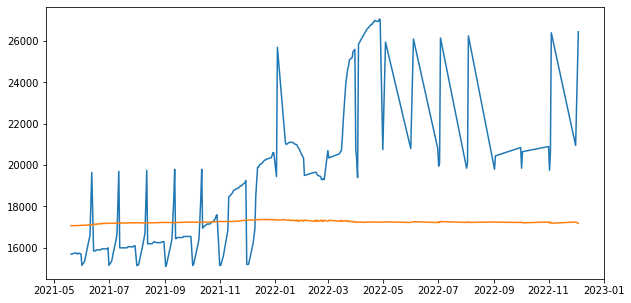

In [15]:
prediction = forecast_predict(model, test_minyakgoreng1_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_minyakgoreng1 = pd.DataFrame()
data_new_minyakgoreng1['date'] = y_test
data_new_minyakgoreng1['actual'] = x_test
data_new_minyakgoreng1['prediction'] = data_result
data_new_minyakgoreng1.to_csv('minyakgoreng1_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_minyakgoreng1.date, data_new_minyakgoreng1.actual)
plt.plot(data_new_minyakgoreng1.date, data_new_minyakgoreng1.prediction)
data_new_minyakgoreng1

#### type2

In [16]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0087 - mae: 0.0788 - mape: 325360.4688 - val_loss: 0.0196 - val_mae: 0.0828 - val_mape: 35.0349
Epoch 2/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0080 - mae: 0.0758 - mape: 304267.0625 - val_loss: 0.0196 - val_mae: 0.0836 - val_mape: 35.8213
Epoch 3/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0077 - mae: 0.0742 - mape: 240145.2188 - val_loss: 0.0196 - val_mae: 0.0845 - val_mape: 36.5931
Epoch 4/30
718/718 [==============================] - 28s 38ms/step - loss: 0.0076 - mae: 0.0735 - mape: 298659.3750 - val_loss: 0.0197 - val_mae: 0.0843 - val_mape: 36.3455
Epoch 5/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0075 - mae: 0.0729 - mape: 297635.3750 - val_loss: 0.0197 - val_mae: 0.0846 - val_mape: 36.5760
Epoch 6/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0074 - mae: 0.0717 - mape: 294829.7188 - val_loss: 0

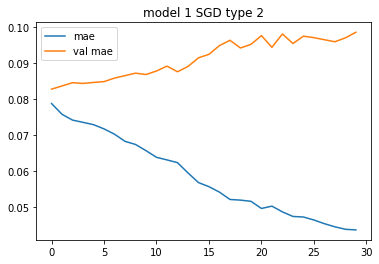

In [17]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 7ms/step
2061.9807 9.536581 3132.1933209813214


,date,actual,prediction
0,2021-05-20,15700,17071.259766
1,2021-05-21,15700,17071.685547
2,2021-05-24,15750,17074.820312
3,2021-05-25,15750,17073.964844
4,2021-05-27,15700,17079.119141
...,...,...,...
229,2022-11-02,19750,17197.806641
230,2022-11-03,20600,17249.261719
231,2022-11-04,26400,17189.306641
232,2022-12-01,20950,17247.111328


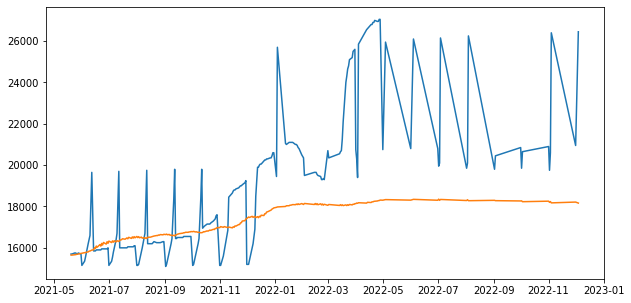

In [18]:
win_size1 = 60
test_minyakgoreng1_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_minyakgoreng1_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_minyakgoreng1_1 = pd.DataFrame()
data_new_minyakgoreng1_1['actual'] = x_test
data_new_minyakgoreng1_1['prediction'] = data_result_1
data_new_minyakgoreng1_1.to_csv('minyakgoreng1_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng1_1.actual)
plt.plot(y_test, data_new_minyakgoreng1_1.prediction)
data_new_minyakgoreng1

#### type3

In [19]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 134ms/step - loss: 0.0050 - mae: 0.0482 - mape: 52.4660 - val_loss: 0.0202 - val_mae: 0.0906 - val_mape: 41.1454
Epoch 2/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0048 - mae: 0.0453 - mape: 46.3425 - val_loss: 0.0203 - val_mae: 0.0885 - val_mape: 39.1517
Epoch 3/30
84/84 [==============================] - 11s 132ms/step - loss: 0.0048 - mae: 0.0441 - mape: 42.6226 - val_loss: 0.0203 - val_mae: 0.0883 - val_mape: 38.9481
Epoch 4/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0048 - mae: 0.0441 - mape: 42.8242 - val_loss: 0.0203 - val_mae: 0.0889 - val_mape: 39.5443
Epoch 5/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0048 - mae: 0.0439 - mape: 43.0636 - val_loss: 0.0203 - val_mae: 0.0883 - val_mape: 39.0133
Epoch 6/30
84/84 [==============================] - 12s 137ms/step - loss: 0.0048 - mae: 0.0436 - mape: 41.9499 - val_loss: 0.0203 - val_mae: 0.0887 - val_

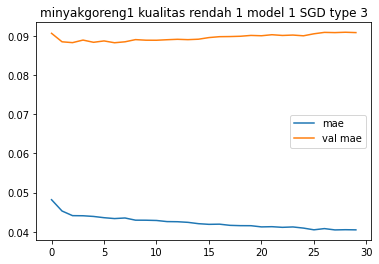

In [20]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('minyakgoreng1 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 12ms/step
2058.613 9.452671 3162.3130774798374


,actual,prediction
0,15700,15256.489258
1,15700,15257.751953
2,15750,15269.076172
3,15750,15272.059570
4,15700,15293.104492
...,...,...
229,19750,18175.304688
230,20600,18209.830078
231,26400,18146.804688
232,20950,18184.365234


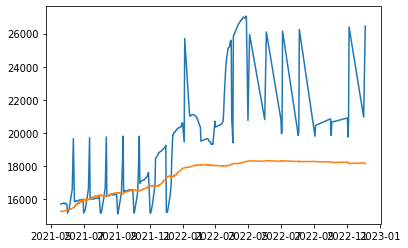

In [21]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_minyakgoreng1_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_minyakgoreng1_2 = pd.DataFrame()
# data_new_minyakgoreng11['date'] = date_test
data_new_minyakgoreng1_2['actual'] = x_test
data_new_minyakgoreng1_2['prediction'] = data_result_2
data_new_minyakgoreng1_2.to_csv('minyakgoreng1_model1_sgd_type3')

plt.plot(y_test, data_new_minyakgoreng1_2.actual)
plt.plot(y_test, data_new_minyakgoreng1_2.prediction)
data_new_minyakgoreng1_2

### Adam

In [22]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [23]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 14s 223ms/step - loss: 0.0418 - mae: 0.1976 - mape: 80.0280 - val_loss: 0.0375 - val_mae: 0.1343 - val_mape: 51.7816
Epoch 2/30
44/44 [==============================] - 9s 201ms/step - loss: 0.0134 - mae: 0.1026 - mape: 40.6217 - val_loss: 0.0197 - val_mae: 0.0897 - val_mape: 40.9371
Epoch 3/30
44/44 [==============================] - 9s 195ms/step - loss: 0.0024 - mae: 0.0365 - mape: 15.1870 - val_loss: 0.0203 - val_mae: 0.1048 - val_mape: 52.7493
Epoch 4/30
44/44 [==============================] - 9s 200ms/step - loss: 0.0024 - mae: 0.0363 - mape: 14.8030 - val_loss: 0.0203 - val_mae: 0.1058 - val_mape: 53.4888
Epoch 5/30
44/44 [==============================] - 9s 201ms/step - loss: 0.0024 - mae: 0.0364 - mape: 15.0546 - val_loss: 0.0202 - val_mae: 0.1045 - val_mape: 52.5703
Epoch 6/30
44/44 [==============================] - 9s 200ms/step - loss: 0.0024 - mae: 0.0360 - mape: 14.8927 - val_loss: 0.0202 - val_mae: 0.1040 - val_mape:

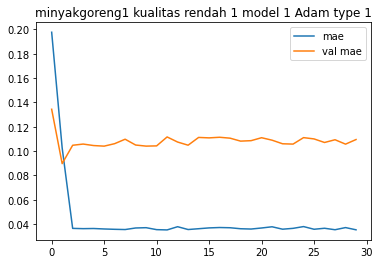

In [24]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('minyakgoreng1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 25ms/step
1921.6799 9.23104 2759.155486738651


,actual,prediction
0,15700,16483.263672
1,15700,16485.927734
2,15750,16491.828125
3,15750,16498.156250
4,15700,16506.603516
...,...,...
229,19750,19834.191406
230,20600,19732.789062
231,26400,19782.539062
232,20950,19678.207031


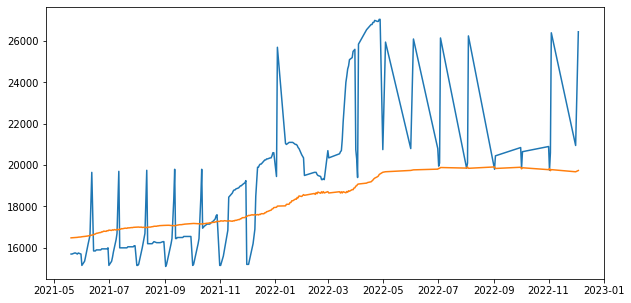

In [25]:
prediction_a = forecast_predict(model_a, test_minyakgoreng1_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_minyakgoreng1_a = pd.DataFrame()
# data_new_minyakgoreng11['date'] = date_test
data_new_minyakgoreng1_a['actual'] = x_test
data_new_minyakgoreng1_a['prediction'] = data_result_a
data_new_minyakgoreng1_a.to_csv('minyakgoreng1_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_minyakgoreng1_a.actual)
plt.plot(y_test, data_new_minyakgoreng1_a.prediction)
data_new_minyakgoreng1_a

#### Type 2

In [26]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0045 - mae: 0.0461 - mape: 180999.8594 - val_loss: 0.0204 - val_mae: 0.1035 - val_mape: 51.6360
Epoch 2/30
718/718 [==============================] - 29s 41ms/step - loss: 0.0043 - mae: 0.0423 - mape: 233366.6562 - val_loss: 0.0201 - val_mae: 0.0934 - val_mape: 43.7853
Epoch 3/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0040 - mae: 0.0391 - mape: 223343.0000 - val_loss: 0.0203 - val_mae: 0.0953 - val_mape: 45.3112
Epoch 4/30
718/718 [==============================] - 27s 38ms/step - loss: 0.0040 - mae: 0.0396 - mape: 229728.0938 - val_loss: 0.0204 - val_mae: 0.0933 - val_mape: 43.6309
Epoch 5/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0040 - mae: 0.0388 - mape: 252762.5469 - val_loss: 0.0205 - val_mae: 0.0955 - val_mape: 45.4320
Epoch 6/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0040 - mae: 0.0399 - mape: 238283.6562 - val_loss: 0

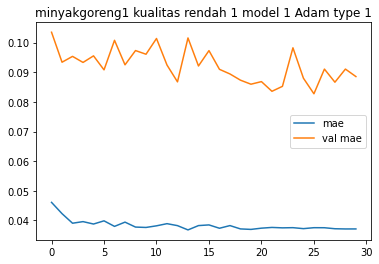

In [27]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('minyakgoreng1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 7ms/step
1468.4694 7.057026 2096.770373693791


,actual,prediction
0,15700,15245.015625
1,15700,15253.484375
2,15750,15270.698242
3,15750,15296.650391
4,15700,15325.696289
...,...,...
229,19750,22643.734375
230,20600,22434.412109
231,26400,22531.998047
232,20950,22289.689453


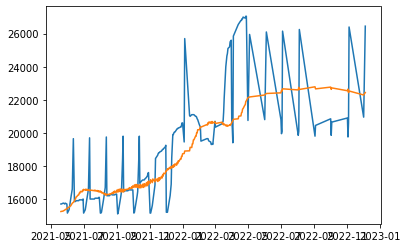

In [28]:
prediction_a1 = forecast_predict(model_a, test_minyakgoreng1_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_minyakgoreng1_a1 = pd.DataFrame()
data_new_minyakgoreng1_a1['actual'] = x_test
data_new_minyakgoreng1_a1['prediction'] = data_result_a1
data_new_minyakgoreng1_a1.to_csv('minyakgoreng1_model1_adam_type2.csv')

plt.plot(y_test, data_new_minyakgoreng1_a1.actual)
plt.plot(y_test, data_new_minyakgoreng1_a1.prediction)
data_new_minyakgoreng1_a1

#### Type 3

In [29]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 132ms/step - loss: 0.0040 - mae: 0.0341 - mape: 29.0433 - val_loss: 0.0212 - val_mae: 0.0835 - val_mape: 34.8030
Epoch 2/30
84/84 [==============================] - 11s 133ms/step - loss: 0.0039 - mae: 0.0319 - mape: 25.1377 - val_loss: 0.0212 - val_mae: 0.0832 - val_mape: 34.5375
Epoch 3/30
84/84 [==============================] - 11s 129ms/step - loss: 0.0039 - mae: 0.0317 - mape: 24.9488 - val_loss: 0.0213 - val_mae: 0.0828 - val_mape: 34.0807
Epoch 4/30
84/84 [==============================] - 11s 130ms/step - loss: 0.0039 - mae: 0.0319 - mape: 25.7027 - val_loss: 0.0210 - val_mae: 0.0849 - val_mape: 36.3088
Epoch 5/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0039 - mae: 0.0318 - mape: 24.2868 - val_loss: 0.0211 - val_mae: 0.0844 - val_mape: 35.7776
Epoch 6/30
84/84 [==============================] - 11s 132ms/step - loss: 0.0039 - mae: 0.0324 - mape: 26.2132 - val_loss: 0.0213 - val_mae: 0.0829 - val_

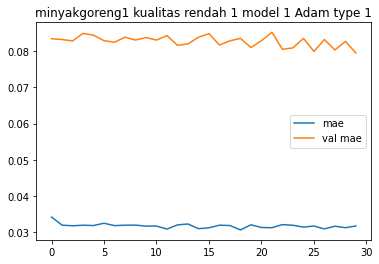

In [30]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('minyakgoreng1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 12ms/step
1554.0459 7.3729625 2257.400385399099


,actual,prediction
0,15700,14999.762695
1,15700,15011.201172
2,15750,15031.532227
3,15750,15061.957031
4,15700,15092.216797
...,...,...
229,19750,22039.230469
230,20600,21716.337891
231,26400,21884.109375
232,20950,21549.521484


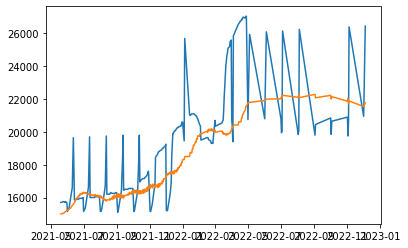

In [31]:
prediction_a2 = forecast_predict(model_a, test_minyakgoreng1_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_minyakgoreng1_a2 = pd.DataFrame()
# data_new_minyakgoreng11['date'] = date_test
data_new_minyakgoreng1_a2['actual'] = x_test
data_new_minyakgoreng1_a2['prediction'] = data_result_a2
data_new_minyakgoreng1_a2.to_csv('minyakgoreng1_model1_adam_type3.csv')

plt.plot(y_test, data_new_minyakgoreng1_a2.actual)
plt.plot(y_test, data_new_minyakgoreng1_a2.prediction)
data_new_minyakgoreng1_a2

## model 1

### Adam

In [32]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [33]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 20s 354ms/step - loss: 0.0297 - mae: 0.1558 - mape: 63.6914 - val_loss: 0.0221 - val_mae: 0.1205 - val_mape: 64.7389
Epoch 2/15
44/44 [==============================] - 14s 322ms/step - loss: 0.0034 - mae: 0.0454 - mape: 18.7635 - val_loss: 0.0219 - val_mae: 0.1196 - val_mape: 64.0604
Epoch 3/15
44/44 [==============================] - 14s 319ms/step - loss: 0.0025 - mae: 0.0371 - mape: 15.1539 - val_loss: 0.0219 - val_mae: 0.1193 - val_mape: 63.8052
Epoch 4/15
44/44 [==============================] - 15s 343ms/step - loss: 0.0027 - mae: 0.0400 - mape: 16.4295 - val_loss: 0.0219 - val_mae: 0.1196 - val_mape: 64.0093
Epoch 5/15
44/44 [==============================] - 14s 320ms/step - loss: 0.0026 - mae: 0.0380 - mape: 15.6749 - val_loss: 0.0207 - val_mae: 0.1101 - val_mape: 56.8750
Epoch 6/15
44/44 [==============================] - 14s 326ms/step - loss: 0.0024 - mae: 0.0358 - mape: 14.6685 - val_loss: 0.0206 - val_mae: 0.1094 - val_

17/17 [==============================] - 0s 17ms/step - loss: 0.1052 - mae: 0.2433 - mape: 33.5925


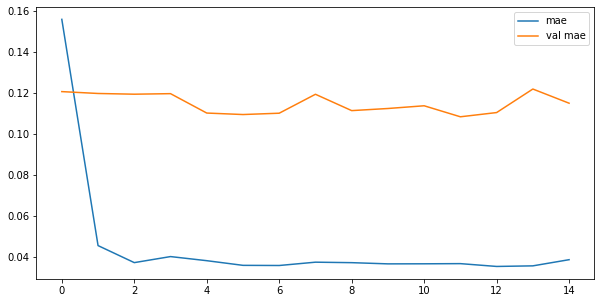

In [36]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [37]:
prediction1 = forecast_predict(model1, test_minyakgoreng1_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_minyakgoreng11 = pd.DataFrame()
data_new_minyakgoreng11['actual'] = x_test
data_new_minyakgoreng11['prediction'] = data_result1
data_new_minyakgoreng11.to_csv('minyakgoreng1_model2_adam_type1.csv')

data_new_minyakgoreng11

131/131 [==============================] - 5s 34ms/step
2879.0063 13.343498 4109.95012135184


,actual,prediction
0,15700,15518.636719
1,15700,15518.922852
2,15750,15520.424805
3,15750,15521.361328
4,15700,15523.985352
...,...,...
229,19750,16847.371094
230,20600,16786.937500
231,26400,16825.093750
232,20950,16765.513672


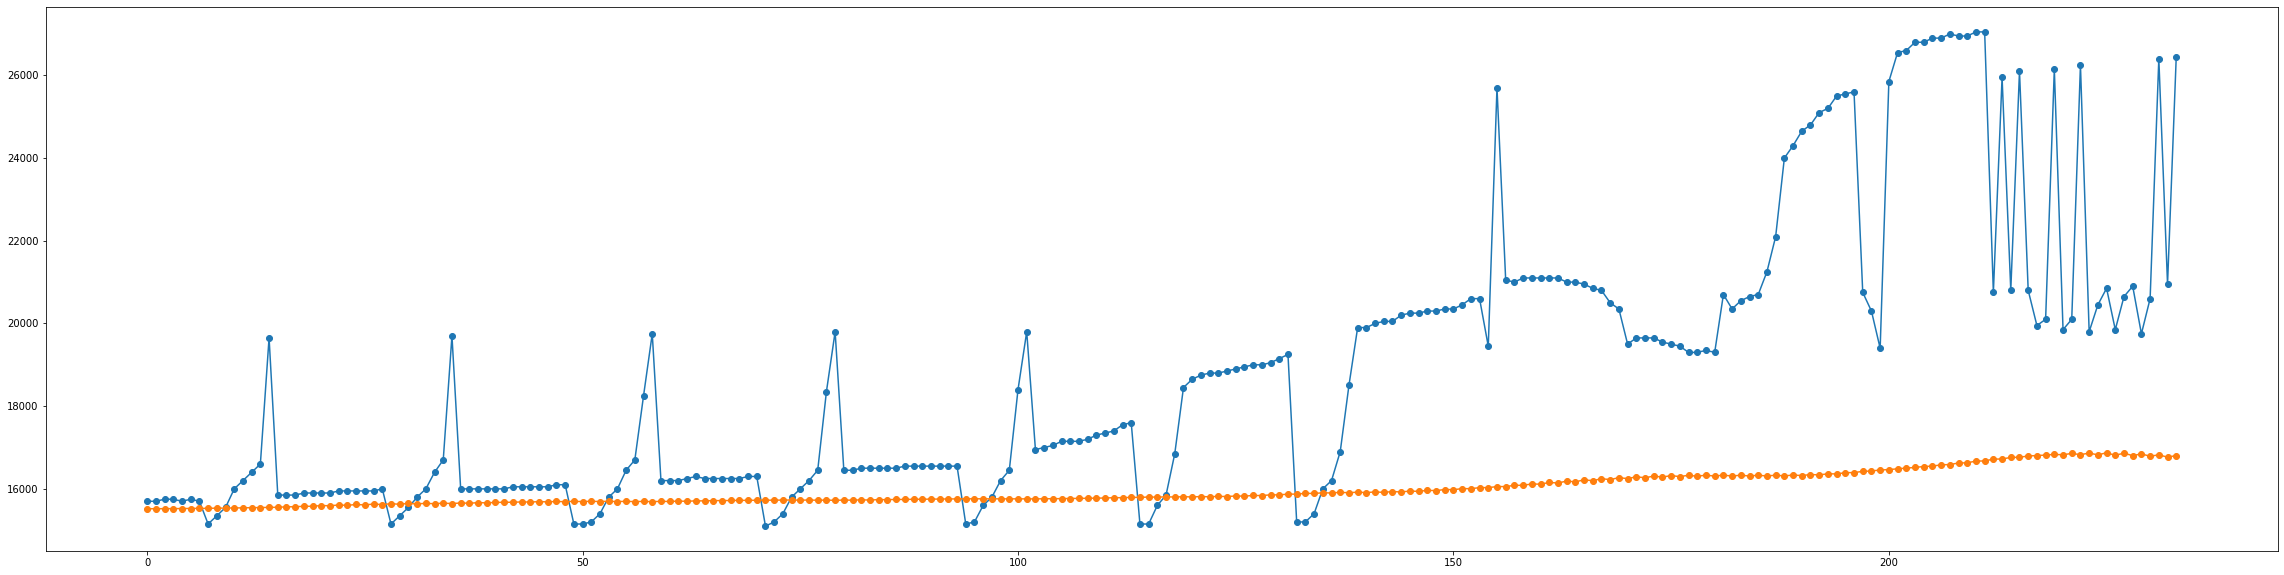

In [38]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_minyakgoreng11['actual'], '-o')
plt.plot(range(len(x_test)), data_new_minyakgoreng11['prediction'], '-o')

#### Type 2

In [39]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 33s 46ms/step - loss: 0.0049 - mae: 0.0486 - mape: 266300.9375 - val_loss: 0.0206 - val_mae: 0.1050 - val_mape: 52.9626
Epoch 2/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0041 - mae: 0.0402 - mape: 310136.9688 - val_loss: 0.0204 - val_mae: 0.0832 - val_mape: 34.6809
Epoch 3/15
718/718 [==============================] - 32s 45ms/step - loss: 0.0040 - mae: 0.0380 - mape: 250067.6250 - val_loss: 0.0200 - val_mae: 0.0895 - val_mape: 40.5226
Epoch 4/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0039 - mae: 0.0390 - mape: 198079.6406 - val_loss: 0.0206 - val_mae: 0.1063 - val_mape: 53.9728
Epoch 5/15
718/718 [==============================] - 33s 46ms/step - loss: 0.0040 - mae: 0.0397 - mape: 245259.8594 - val_loss: 0.0207 - val_mae: 0.0802 - val_mape: 32.0460
Epoch 6/15
718/718 [==============================] - 32s 45ms/step - loss: 0.0039 - mae: 0.0380 - mape: 250796.9531 - val_loss: 0

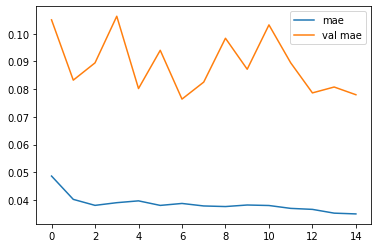

In [40]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 9ms/step
2665.718 12.535554 4109.95012135184


,actual,prediction
0,15700,14972.561523
1,15700,14972.743164
2,15750,14972.651367
3,15750,14974.203125
4,15700,14978.231445
...,...,...
229,19750,18343.500000
230,20600,17785.152344
231,26400,18108.148438
232,20950,17303.644531


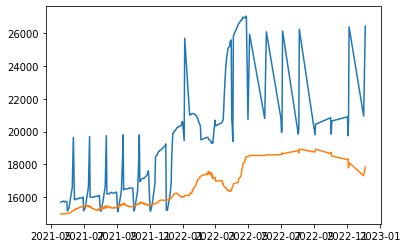

In [41]:
prediction1_1 = forecast_predict(model1, test_minyakgoreng1_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_minyakgoreng11_1 = pd.DataFrame()
data_new_minyakgoreng11_1['actual'] = x_test
data_new_minyakgoreng11_1['prediction'] = data_result1_1
data_new_minyakgoreng11_1.to_csv('minyakgoreng1_model2_adam_type2.csv')

plt.plot(y_test, data_new_minyakgoreng11_1.actual)
plt.plot(y_test, data_new_minyakgoreng11_1.prediction)
data_new_minyakgoreng11_1

#### Type 3

In [42]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 19s 227ms/step - loss: 0.0038 - mae: 0.0298 - mape: 22.5636 - val_loss: 0.0182 - val_mae: 0.0775 - val_mape: 34.2505
Epoch 2/15
84/84 [==============================] - 18s 217ms/step - loss: 0.0037 - mae: 0.0307 - mape: 24.5516 - val_loss: 0.0183 - val_mae: 0.0767 - val_mape: 33.2354
Epoch 3/15
84/84 [==============================] - 18s 217ms/step - loss: 0.0037 - mae: 0.0305 - mape: 24.6000 - val_loss: 0.0187 - val_mae: 0.0759 - val_mape: 31.6860
Epoch 4/15
84/84 [==============================] - 18s 218ms/step - loss: 0.0037 - mae: 0.0303 - mape: 24.1669 - val_loss: 0.0185 - val_mae: 0.0756 - val_mape: 31.9789
Epoch 5/15
84/84 [==============================] - 18s 218ms/step - loss: 0.0037 - mae: 0.0293 - mape: 22.0930 - val_loss: 0.0182 - val_mae: 0.0766 - val_mape: 33.8134
Epoch 6/15
84/84 [==============================] - 18s 217ms/step - loss: 0.0037 - mae: 0.0310 - mape: 25.3190 - val_loss: 0.0183 - val_mae: 0.0757 - val_

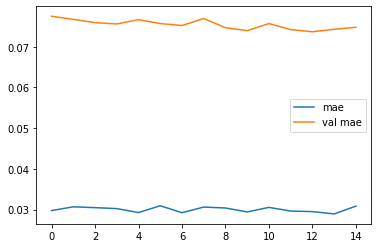

In [43]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 17ms/step
2680.0483 12.586337 4109.95012135184


,actual,prediction
0,15700,14986.758789
1,15700,14986.974609
2,15750,14990.250000
3,15750,14993.021484
4,15700,15004.549805
...,...,...
229,19750,18250.746094
230,20600,17564.962891
231,26400,18016.435547
232,20950,17051.521484


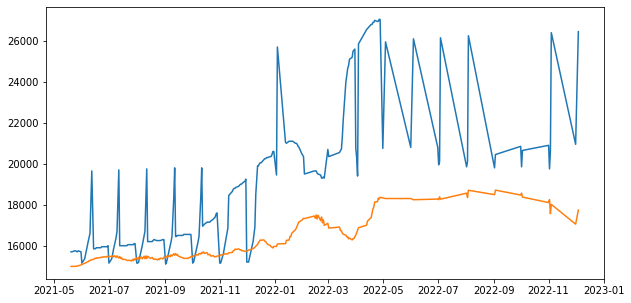

In [44]:
prediction1_2 = forecast_predict(model1, test_minyakgoreng1_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_minyakgoreng11_2 = pd.DataFrame()
data_new_minyakgoreng11_2['actual'] = x_test
data_new_minyakgoreng11_2['prediction'] = data_result1_2
data_new_minyakgoreng11_2.to_csv('minyakgoreng1_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng11_2.actual)
plt.plot(y_test, data_new_minyakgoreng11_2.prediction)

data_new_minyakgoreng11_2

### SGD

In [45]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [46]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [47]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 20s 353ms/step - loss: 0.0556 - mae: 0.2305 - mape: 93.8283 - val_loss: 0.0507 - val_mae: 0.1779 - val_mape: 76.5933
Epoch 2/15
44/44 [==============================] - 14s 325ms/step - loss: 0.0344 - mae: 0.1783 - mape: 71.5702 - val_loss: 0.0364 - val_mae: 0.1313 - val_mape: 50.2759
Epoch 3/15
44/44 [==============================] - 15s 349ms/step - loss: 0.0218 - mae: 0.1393 - mape: 55.1147 - val_loss: 0.0288 - val_mae: 0.1014 - val_mape: 34.8064
Epoch 4/15
44/44 [==============================] - 15s 330ms/step - loss: 0.0145 - mae: 0.1102 - mape: 42.7892 - val_loss: 0.0246 - val_mae: 0.0849 - val_mape: 28.2793
Epoch 5/15
44/44 [==============================] - 15s 331ms/step - loss: 0.0101 - mae: 0.0886 - mape: 33.8677 - val_loss: 0.0221 - val_mae: 0.0759 - val_mape: 25.8880
Epoch 6/15
44/44 [==============================] - 14s 328ms/step - loss: 0.0072 - mae: 0.0716 - mape: 26.9789 - val_loss: 0.0206 - val_mae: 0.0763 - val_

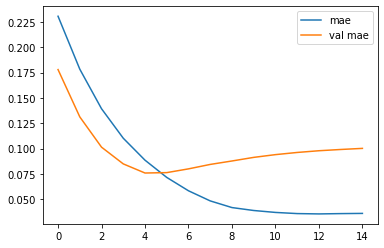

In [48]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 5s 34ms/step
3115.096 14.406079 4459.510062775955


,actual,prediction
0,15700,15598.269531
1,15700,15598.819336
2,15750,15599.951172
3,15750,15600.891602
4,15700,15602.739258
...,...,...
229,19750,15812.310547
230,20600,15810.370117
231,26400,15812.916992
232,20950,15809.931641


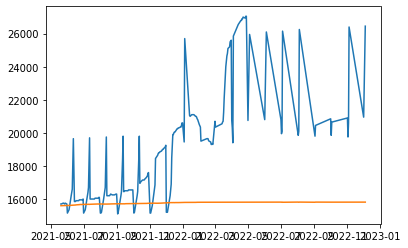

In [49]:
prediction1_a = forecast_predict(model1_a, test_minyakgoreng1_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_minyakgoreng11_a = pd.DataFrame()
data_new_minyakgoreng11_a['actual'] = x_test
data_new_minyakgoreng11_a['prediction'] = data_result1_a
data_new_minyakgoreng11_a.to_csv('minyakgoreng1_model2_sgd_type1.csv')


plt.plot(y_test, data_new_minyakgoreng11_a.actual)
plt.plot(y_test, data_new_minyakgoreng11_a.prediction)

data_new_minyakgoreng11_a

#### Type 2


In [50]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 33s 45ms/step - loss: 0.0077 - mae: 0.0723 - mape: 292141.7188 - val_loss: 0.0197 - val_mae: 0.0857 - val_mape: 37.4028
Epoch 2/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0068 - mae: 0.0673 - mape: 272374.0312 - val_loss: 0.0197 - val_mae: 0.0879 - val_mape: 39.4049
Epoch 3/15
718/718 [==============================] - 31s 44ms/step - loss: 0.0062 - mae: 0.0622 - mape: 284271.2500 - val_loss: 0.0197 - val_mae: 0.0900 - val_mape: 41.1557
Epoch 4/15
718/718 [==============================] - 31s 44ms/step - loss: 0.0059 - mae: 0.0609 - mape: 289664.0312 - val_loss: 0.0198 - val_mae: 0.0911 - val_mape: 42.1224
Epoch 5/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0056 - mae: 0.0583 - mape: 235453.9531 - val_loss: 0.0198 - val_mae: 0.0926 - val_mape: 43.3419
Epoch 6/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0054 - mae: 0.0558 - mape: 299593.0625 - val_loss: 0

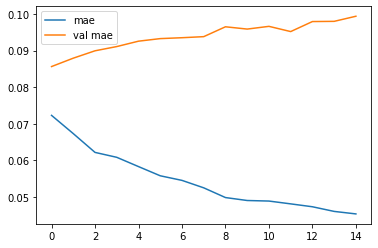

In [51]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 8ms/step
3093.641 14.435072 4323.736347188621


,actual,prediction
0,15700,15162.675781
1,15700,15163.479492
2,15750,15166.416016
3,15750,15168.997070
4,15700,15174.364258
...,...,...
229,19750,16172.218750
230,20600,16165.206055
231,26400,16165.576172
232,20950,16158.706055


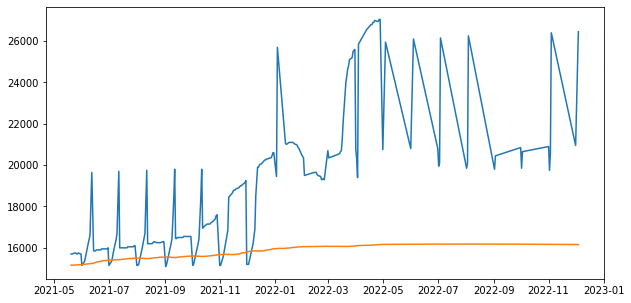

In [52]:
prediction1_a1 = forecast_predict(model1_a, test_minyakgoreng1_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_minyakgoreng11_a1 = pd.DataFrame()
data_new_minyakgoreng11_a1['actual'] = x_test
data_new_minyakgoreng11_a1['prediction'] = data_result1_a1
data_new_minyakgoreng11_a1.to_csv('minyakgoreng1_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng11_a1.actual)
plt.plot(y_test, data_new_minyakgoreng11_a1.prediction)
data_new_minyakgoreng11_a1

#### Type 3

In [53]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 19s 226ms/step - loss: 0.0052 - mae: 0.0494 - mape: 54.1318 - val_loss: 0.0203 - val_mae: 0.0925 - val_mape: 42.7115
Epoch 2/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0049 - mae: 0.0459 - mape: 47.0864 - val_loss: 0.0204 - val_mae: 0.0903 - val_mape: 40.6622
Epoch 3/15
84/84 [==============================] - 18s 214ms/step - loss: 0.0048 - mae: 0.0445 - mape: 43.6103 - val_loss: 0.0204 - val_mae: 0.0893 - val_mape: 39.7918
Epoch 4/15
84/84 [==============================] - 18s 217ms/step - loss: 0.0048 - mae: 0.0442 - mape: 43.2682 - val_loss: 0.0204 - val_mae: 0.0899 - val_mape: 40.2854
Epoch 5/15
84/84 [==============================] - 19s 219ms/step - loss: 0.0048 - mae: 0.0439 - mape: 42.1880 - val_loss: 0.0204 - val_mae: 0.0898 - val_mape: 40.2088
Epoch 6/15
84/84 [==============================] - 18s 218ms/step - loss: 0.0048 - mae: 0.0436 - mape: 41.8591 - val_loss: 0.0204 - val_mae: 0.0901 - val_

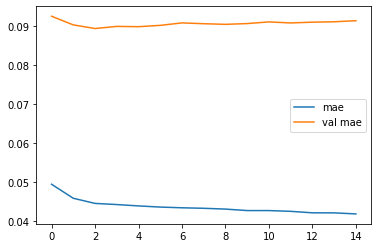

In [54]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 16ms/step
3145.7097 14.7409725 4343.17855953448


,actual,prediction
0,15700,15060.184570
1,15700,15060.246094
2,15750,15060.171875
3,15750,15060.057617
4,15700,15061.170898
...,...,...
229,19750,16173.001953
230,20600,16166.386719
231,26400,16165.978516
232,20950,16158.750000


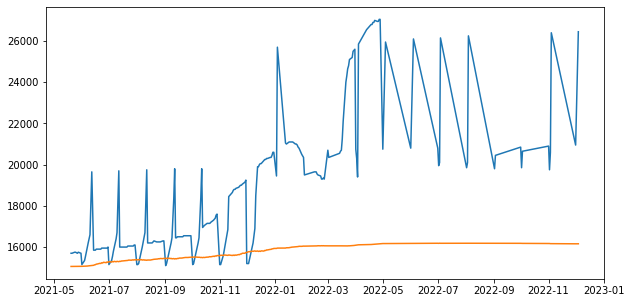

In [55]:
prediction1_a2 = forecast_predict(model1_a, test_minyakgoreng1_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_minyakgoreng11_a2 = pd.DataFrame()
data_new_minyakgoreng11_a2['actual'] = x_test
data_new_minyakgoreng11_a2['prediction'] = data_result1_a2
data_new_minyakgoreng11_a2.to_csv('minyakgoreng1_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng11_a2.actual)
plt.plot(y_test, data_new_minyakgoreng11_a2.prediction)

data_new_minyakgoreng11_a2

## model 2

### SGD

In [56]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [57]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [58]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 10s 137ms/step - loss: 0.0566 - mae: 0.2324 - mape: 94.5361 - val_loss: 0.0541 - val_mae: 0.1870 - val_mape: 81.6563
Epoch 2/50
44/44 [==============================] - 5s 113ms/step - loss: 0.0408 - mae: 0.1957 - mape: 79.0434 - val_loss: 0.0423 - val_mae: 0.1521 - val_mape: 61.9929
Epoch 3/50
44/44 [==============================] - 5s 113ms/step - loss: 0.0294 - mae: 0.1640 - mape: 65.5194 - val_loss: 0.0343 - val_mae: 0.1229 - val_mape: 45.5562
Epoch 4/50
44/44 [==============================] - 5s 113ms/step - loss: 0.0214 - mae: 0.1375 - mape: 54.2395 - val_loss: 0.0288 - val_mae: 0.1016 - val_mape: 34.8590
Epoch 5/50
44/44 [==============================] - 5s 114ms/step - loss: 0.0158 - mae: 0.1153 - mape: 44.8229 - val_loss: 0.0252 - val_mae: 0.0875 - val_mape: 29.1231
Epoch 6/50
44/44 [==============================] - 5s 113ms/step - loss: 0.0118 - mae: 0.0971 - mape: 37.2977 - val_loss: 0.0228 - val_mae: 0.0785 - val_mape:

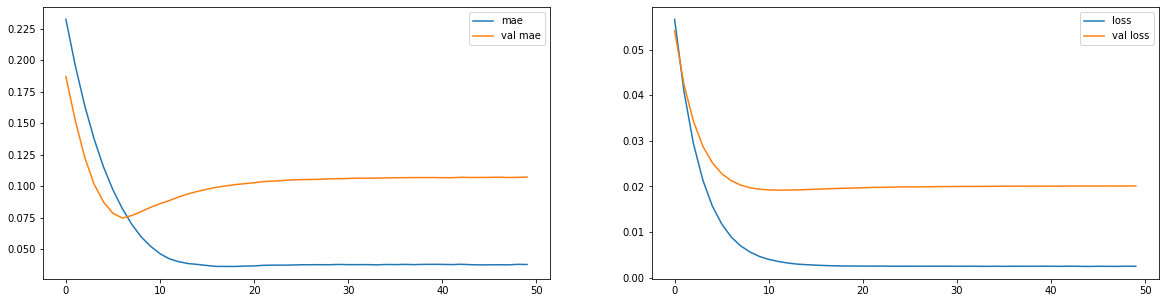

In [59]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 3s 16ms/step
3080.0728 14.207712 4443.69508404886


,actual,prediction
0,15700,15723.311523
1,15700,15723.504883
2,15750,15725.000000
3,15750,15724.658203
4,15700,15725.511719
...,...,...
229,19750,15825.649414
230,20600,15824.139648
231,26400,15824.743164
232,20950,15824.248047


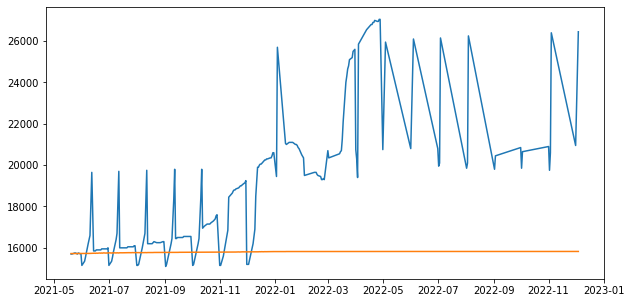

In [60]:
prediction2 = forecast_predict(model2, test_minyakgoreng1_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_minyakgoreng12 = pd.DataFrame()
data_new_minyakgoreng12['actual'] = x_test
data_new_minyakgoreng12['prediction'] = data_result2
data_new_minyakgoreng12.to_csv('minyakgoreng1_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng12.actual)
plt.plot(y_test, data_new_minyakgoreng12.prediction)
data_new_minyakgoreng12

#### Type2

In [61]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0093 - mae: 0.0810 - mape: 345798.3438 - val_loss: 0.0195 - val_mae: 0.0840 - val_mape: 36.1584
Epoch 2/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0088 - mae: 0.0799 - mape: 242931.3281 - val_loss: 0.0195 - val_mae: 0.0848 - val_mape: 36.8632
Epoch 3/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0085 - mae: 0.0790 - mape: 295548.3125 - val_loss: 0.0195 - val_mae: 0.0857 - val_mape: 37.6507
Epoch 4/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0084 - mae: 0.0772 - mape: 190759.7969 - val_loss: 0.0195 - val_mae: 0.0869 - val_mape: 38.6930
Epoch 5/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0082 - mae: 0.0767 - mape: 289421.5000 - val_loss: 0.0195 - val_mae: 0.0874 - val_mape: 39.1780
Epoch 6/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0080 - mae: 0.0756 - mape: 310050.3125 - val_loss: 0

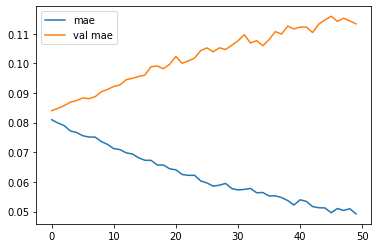

In [62]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [63]:
prediction2_1 = forecast_predict(model2, test_minyakgoreng1_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_minyakgoreng12_1 = pd.DataFrame()
data_new_minyakgoreng12_1['actual'] = x_test
data_new_minyakgoreng12_1['prediction'] = data_result2_1
data_new_minyakgoreng12_1.to_csv('minyakgoreng1_model3_sgd_type2.csv')

data_new_minyakgoreng12

199/199 [==============================] - 1s 5ms/step
3118.2478 14.553754 4352.77796355385


,actual,prediction
0,15700,15723.311523
1,15700,15723.504883
2,15750,15725.000000
3,15750,15724.658203
4,15700,15725.511719
...,...,...
229,19750,15825.649414
230,20600,15824.139648
231,26400,15824.743164
232,20950,15824.248047


#### Type 3

In [64]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0061 - mae: 0.0570 - mape: 63.3725 - val_loss: 0.0207 - val_mae: 0.1055 - val_mape: 52.9440
Epoch 2/50
84/84 [==============================] - 7s 79ms/step - loss: 0.0057 - mae: 0.0533 - mape: 54.9851 - val_loss: 0.0205 - val_mae: 0.1020 - val_mape: 50.3301
Epoch 3/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0057 - mae: 0.0531 - mape: 52.5259 - val_loss: 0.0205 - val_mae: 0.1011 - val_mape: 49.6438
Epoch 4/50
84/84 [==============================] - 7s 77ms/step - loss: 0.0056 - mae: 0.0522 - mape: 52.0012 - val_loss: 0.0205 - val_mae: 0.1006 - val_mape: 49.2186
Epoch 5/50
84/84 [==============================] - 7s 79ms/step - loss: 0.0056 - mae: 0.0522 - mape: 50.4279 - val_loss: 0.0205 - val_mae: 0.1006 - val_mape: 49.2803
Epoch 6/50
84/84 [==============================] - 7s 79ms/step - loss: 0.0057 - mae: 0.0522 - mape: 50.0775 - val_loss: 0.0205 - val_mae: 0.1006 - val_mape: 49.226

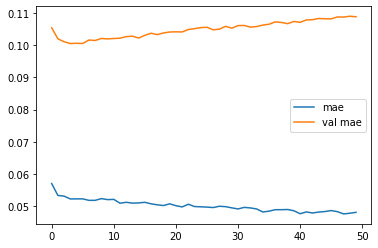

In [65]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [66]:
prediction2_2 = forecast_predict(model2, test_minyakgoreng1_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_minyakgoreng12_2 = pd.DataFrame()
data_new_minyakgoreng12_2['actual'] = x_test
data_new_minyakgoreng12_2['prediction'] = data_result2_2
data_new_minyakgoreng12_2.to_csv('minyakgoreng1_model3_sgd-type3.csv')

data_new_minyakgoreng12_2

181/181 [==============================] - 2s 9ms/step
3154.1262 14.786715 4349.850802039077


,actual,prediction
0,15700,15080.256836
1,15700,15080.152344
2,15750,15080.615234
3,15750,15080.708008
4,15700,15081.348633
...,...,...
229,19750,16178.476562
230,20600,16150.380859
231,26400,16162.789062
232,20950,16152.913086


### Adam

In [67]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [68]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 12s 157ms/step - loss: 0.0423 - mae: 0.1988 - mape: 80.7442 - val_loss: 0.0315 - val_mae: 0.1112 - val_mape: 39.2272
Epoch 2/50
44/44 [==============================] - 6s 131ms/step - loss: 0.0081 - mae: 0.0726 - mape: 29.6434 - val_loss: 0.0209 - val_mae: 0.1119 - val_mape: 57.8560
Epoch 3/50
44/44 [==============================] - 6s 132ms/step - loss: 0.0028 - mae: 0.0390 - mape: 15.9600 - val_loss: 0.0202 - val_mae: 0.1044 - val_mape: 52.2620
Epoch 4/50
44/44 [==============================] - 6s 134ms/step - loss: 0.0027 - mae: 0.0384 - mape: 15.9363 - val_loss: 0.0206 - val_mae: 0.1090 - val_mape: 55.7204
Epoch 5/50
44/44 [==============================] - 6s 137ms/step - loss: 0.0026 - mae: 0.0382 - mape: 15.8560 - val_loss: 0.0203 - val_mae: 0.1054 - val_mape: 53.0621
Epoch 6/50
44/44 [==============================] - 6s 132ms/step - loss: 0.0026 - mae: 0.0371 - mape: 15.3457 - val_loss: 0.0208 - val_mae: 0.1112 - val_mape:

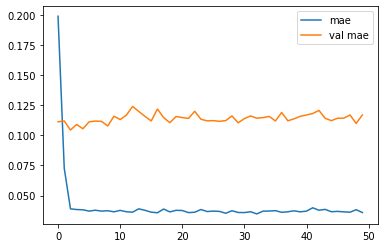

In [69]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [70]:
prediction2_a = forecast_predict(model2_a, test_minyakgoreng1_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_minyakgoreng12_a = pd.DataFrame()
data_new_minyakgoreng12_a['actual'] = x_test
data_new_minyakgoreng12_a['prediction'] = data_result2_a
data_new_minyakgoreng12_a.to_csv('minyakgoreng1_model3_adam-type1.csv')

data_new_minyakgoreng12_a

131/131 [==============================] - 3s 17ms/step
2894.4487 13.389399 4152.673596612188


,actual,prediction
0,15700,15577.056641
1,15700,15576.807617
2,15750,15580.798828
3,15750,15582.228516
4,15700,15583.205078
...,...,...
229,19750,16669.878906
230,20600,16672.042969
231,26400,16716.289062
232,20950,16676.601562


#### Type 2

In [71]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 17s 23ms/step - loss: 0.0051 - mae: 0.0503 - mape: 228405.5312 - val_loss: 0.0209 - val_mae: 0.1100 - val_mape: 56.4262
Epoch 2/50
718/718 [==============================] - 18s 25ms/step - loss: 0.0045 - mae: 0.0454 - mape: 228057.7344 - val_loss: 0.0218 - val_mae: 0.1166 - val_mape: 61.1932
Epoch 3/50
718/718 [==============================] - 16s 23ms/step - loss: 0.0043 - mae: 0.0433 - mape: 199925.1719 - val_loss: 0.0220 - val_mae: 0.1165 - val_mape: 61.2115
Epoch 4/50
718/718 [==============================] - 16s 23ms/step - loss: 0.0043 - mae: 0.0430 - mape: 199598.9062 - val_loss: 0.0221 - val_mae: 0.1168 - val_mape: 61.4343
Epoch 5/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0042 - mae: 0.0419 - mape: 215788.6094 - val_loss: 0.0223 - val_mae: 0.1175 - val_mape: 61.8563
Epoch 6/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0042 - mae: 0.0402 - mape: 228815.1719 - val_loss: 0

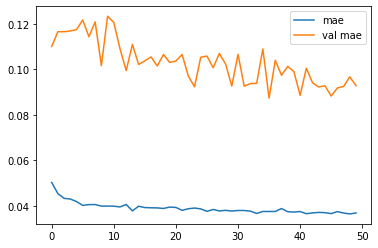

In [72]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 5ms/step
2850.87 13.381645 3939.8314684767925


,actual,prediction
0,15700,15016.963867
1,15700,15017.891602
2,15750,15021.694336
3,15750,15024.919922
4,15700,15024.598633
...,...,...
229,19750,17349.660156
230,20600,17329.148438
231,26400,17417.263672
232,20950,17313.585938


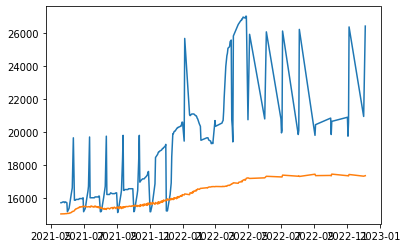

In [73]:
prediction2_a1 = forecast_predict(model2_a, test_minyakgoreng1_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_minyakgoreng12_a1 = pd.DataFrame()
data_new_minyakgoreng12_a1['actual'] = x_test
data_new_minyakgoreng12_a1['prediction'] = data_result2_a1
data_new_minyakgoreng12_a1.to_csv('minyakgoreng1_model3_adam-type2.csv')

plt.plot(y_test, data_new_minyakgoreng12_a1.actual)
plt.plot(y_test, data_new_minyakgoreng12_a1.prediction)
data_new_minyakgoreng12_a1

#### Type 3

In [74]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 7s 85ms/step - loss: 0.0039 - mae: 0.0315 - mape: 23.7544 - val_loss: 0.0219 - val_mae: 0.0918 - val_mape: 41.8510
Epoch 2/50
84/84 [==============================] - 7s 84ms/step - loss: 0.0038 - mae: 0.0310 - mape: 23.8456 - val_loss: 0.0219 - val_mae: 0.0904 - val_mape: 40.5807
Epoch 3/50
84/84 [==============================] - 7s 84ms/step - loss: 0.0039 - mae: 0.0323 - mape: 25.9814 - val_loss: 0.0220 - val_mae: 0.0892 - val_mape: 39.5128
Epoch 4/50
84/84 [==============================] - 7s 84ms/step - loss: 0.0038 - mae: 0.0322 - mape: 25.7962 - val_loss: 0.0219 - val_mae: 0.0890 - val_mape: 39.3603
Epoch 5/50
84/84 [==============================] - 7s 84ms/step - loss: 0.0039 - mae: 0.0314 - mape: 23.6906 - val_loss: 0.0219 - val_mae: 0.0902 - val_mape: 40.4523
Epoch 6/50
84/84 [==============================] - 7s 83ms/step - loss: 0.0039 - mae: 0.0321 - mape: 25.3974 - val_loss: 0.0220 - val_mae: 0.0891 - val_mape: 39.311

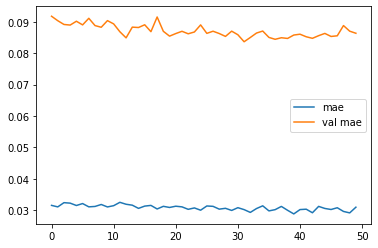

In [75]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 8ms/step
2913.729 13.698755 4002.285597005791


,actual,prediction
0,15700,15017.244141
1,15700,15014.575195
2,15750,15024.619141
3,15750,15054.023438
4,15700,15055.172852
...,...,...
229,19750,17181.443359
230,20600,17066.597656
231,26400,17085.826172
232,20950,17051.423828


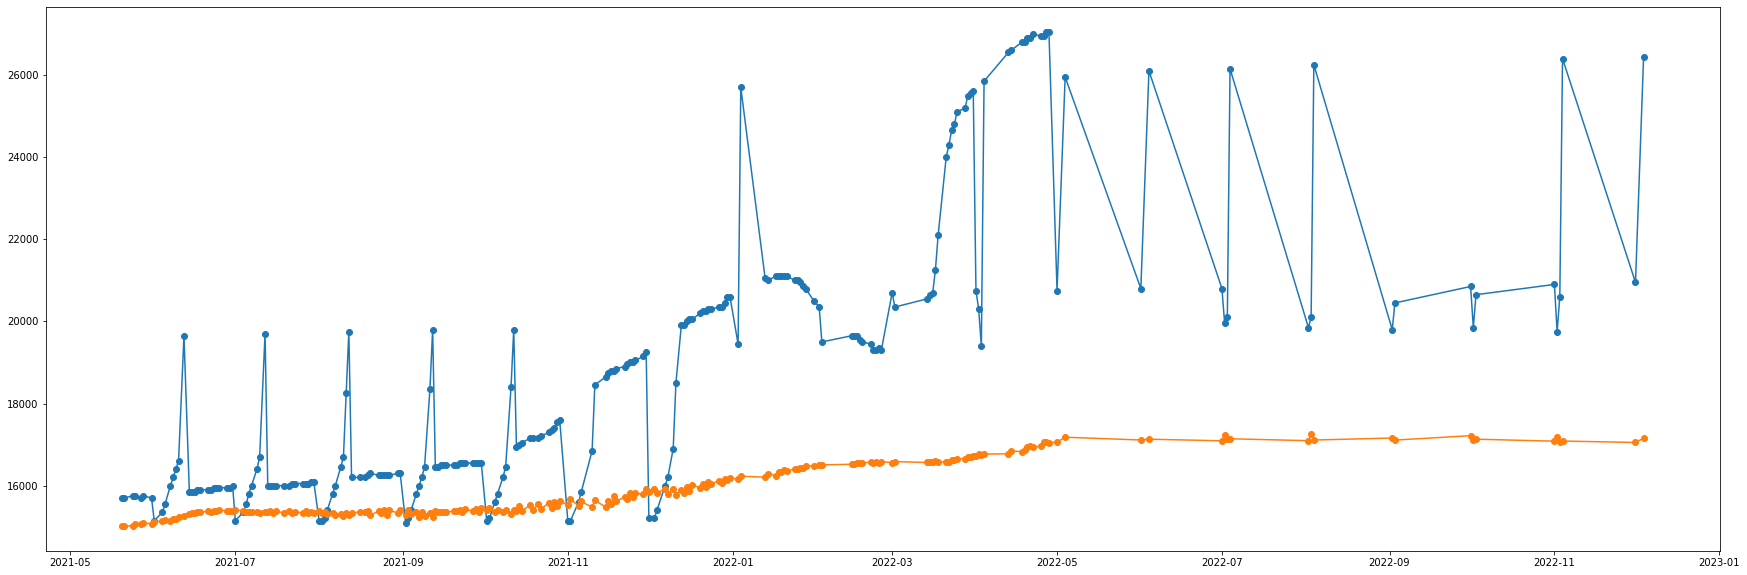

In [76]:
prediction2_a2 = forecast_predict(model2_a, test_minyakgoreng1_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_minyakgoreng12_a2 = pd.DataFrame()
data_new_minyakgoreng12_a2['actual'] = x_test
data_new_minyakgoreng12_a2['prediction'] = data_result2_a2
data_new_minyakgoreng12_a2.to_csv('minyakgoreng1_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_minyakgoreng12_a2.actual, '-o')
plt.plot(y_test,data_new_minyakgoreng12_a2.prediction, '-o')
data_new_minyakgoreng12_a2